# Model from the Saranya paper

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import os

#NN
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

from sklearn.preprocessing import OneHotEncoder

2023-05-13 18:38:41.873455: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Preview images

In [2]:
i = 3
img_1 = cv2.imread(f"banana_dataset_saranya2021/Green/g00{str(i)}.jpg")
img_2 = cv2.imread("banana_dataset_saranya2021/Overripen/v002.jpg")
print("image 1 shape (lines, columns, channels) = ", img_1.shape) 
print("image 2 shape (lines, columns, channels) = ", img_2.shape) 
print("\nimage type: ", type(img_1))

image 1 shape (lines, columns, channels) =  (536, 960, 3)
image 2 shape (lines, columns, channels) =  (540, 960, 3)

image type:  <class 'numpy.ndarray'>


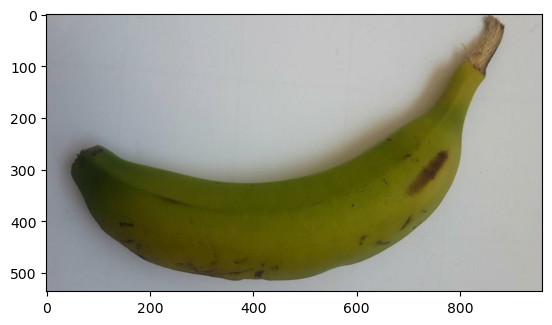

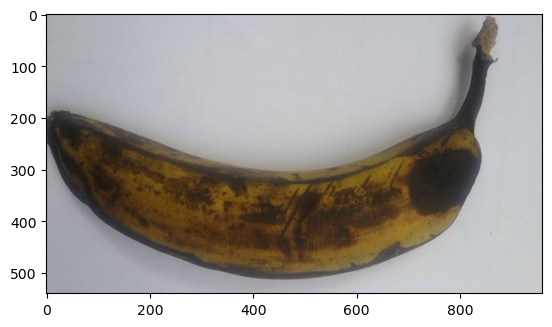

In [3]:
rgb_img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB) # BGR to RGB 
rgb_img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB) # BGR to RGB 
plt.imshow(rgb_img_1)
#plt.axis('off')
plt.show()

plt.imshow(rgb_img_2)
#plt.axis('off')
plt.show()

## Data Pre-processing

Usando padding com zeros para que todas as imagens tenham a mesma dimensão, porque têm pequenas variações.

Também se poderia ter feito crop ou resize, mas pareceu-me a maneira de perder menos informação

In [22]:
# paths to the image folders of each class
class1_path = "banana_dataset_saranya2021/Green"
class2_path = "banana_dataset_saranya2021/Midripen"
class3_path = "banana_dataset_saranya2021/Overripen"
class4_path = "banana_dataset_saranya2021/Yellowish_Green"

# Define empty lists to store the images and labels
images = []
labels = []

# Loop through each folder and extract the images
for class_path, class_label in [(class1_path, 0), (class2_path, 1), (class3_path, 2), (class4_path, 3)]:
    for image_file in os.listdir(class_path):
        # Load the image and convert to RGB format
        image_path = os.path.join(class_path, image_file)
        image = cv2.imread(image_path)
        image = cv2.resize(image, (64, 64))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Add the image and label to the lists
        images.append(image)
        labels.append(class_label)

# Convert the images and labels to NumPy arrays
X = np.array(images)
y = np.array(labels)

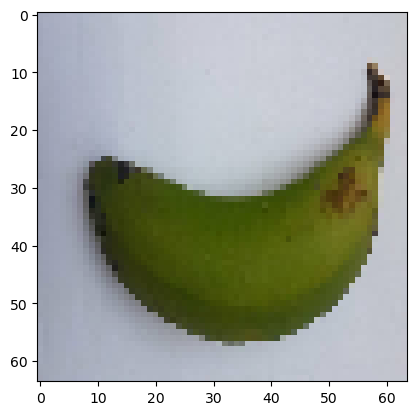

In [23]:
plt.imshow(X[0])
#plt.axis('off')
plt.show()

### One hot encoding of y

In [24]:
y_hot =[ ]
for i in y:
    l = np.zeros(4)
    l[i] = 1
    y_hot.append(l)

y_hot = np.array(y_hot)


In [25]:
X.shape

(273, 64, 64, 3)

### Spliting the data

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y_hot, test_size=0.2, shuffle= True)


## CNN

In [38]:
model = Sequential()

model.add(layers.Conv2D(32, 3, activation = 'relu', padding="valid", input_shape = X[0].shape))
model.add(layers.Conv2D(16, 5, activation = 'relu', strides=(1,1), padding="valid"))
model.add(layers.Conv2D(16, 5, activation = 'relu', padding="valid"))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(16, 3, activation = 'relu', padding="valid"))
model.add(layers.Conv2D(16, 5, activation = 'relu', padding="valid"))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Dropout(0.2))

model.add(layers.Flatten())

model.add(layers.Dense(units = 16, activation = 'relu'))
model.add(layers.Dense(units = 4, activation = 'softmax'))

opt_1 = keras.optimizers.Adam(learning_rate=0.1)

model.compile(optimizer=opt_1,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 conv2d_31 (Conv2D)          (None, 58, 58, 16)        12816     
                                                                 
 conv2d_32 (Conv2D)          (None, 54, 54, 16)        6416      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 27, 27, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 25, 25, 16)        2320      
                                                                 
 conv2d_34 (Conv2D)          (None, 21, 21, 16)        6416      
                                                      

In [40]:
cb_early = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=130,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

cb_plateau = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    verbose=1,
    mode="auto",
    min_delta=0.001,
    cooldown=0,
    min_lr=1e-4,
)

In [41]:
bf = model.fit(X_train, y_train, validation_data=(X_test, y_test), # class_weight
               epochs=60, batch_size=8, callbacks=[cb_early])

Epoch 1/60
28/28 [==============================] - 5s 134ms/step - loss: 51153.1680 - accuracy: 0.2431 - val_loss: 1.3531 - val_accuracy: 0.2727
Epoch 2/60
28/28 [==============================] - 4s 136ms/step - loss: 1.2870 - accuracy: 0.4083 - val_loss: 1.3791 - val_accuracy: 0.2727
Epoch 3/60
28/28 [==============================] - 4s 146ms/step - loss: 1.2829 - accuracy: 0.4083 - val_loss: 1.3818 - val_accuracy: 0.2727
Epoch 4/60
28/28 [==============================] - 4s 160ms/step - loss: 1.2905 - accuracy: 0.4083 - val_loss: 1.3639 - val_accuracy: 0.2727
Epoch 5/60
28/28 [==============================] - 4s 153ms/step - loss: 1.2899 - accuracy: 0.4083 - val_loss: 1.3689 - val_accuracy: 0.2727
Epoch 6/60
28/28 [==============================] - 4s 137ms/step - loss: 1.2988 - accuracy: 0.4083 - val_loss: 1.3772 - val_accuracy: 0.2727
Epoch 7/60
28/28 [==============================] - 4s 159ms/step - loss: 1.2899 - accuracy: 0.4083 - val_loss: 1.3752 - val_accuracy: 0.2727
Ep

KeyboardInterrupt: 